In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp
import cudf
from numba import cuda
from itertools import combinations
from sklearn.preprocessing import MultiLabelBinarizer
from cuml.preprocessing import StandardScaler
from cuml import preprocessing

In [44]:
animes_df = pd.read_csv("../data/animes.csv")
animes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19311 entries, 0 to 19310
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   uid         19311 non-null  int64  
 1   title       19311 non-null  object 
 2   synopsis    18336 non-null  object 
 3   genre       19311 non-null  object 
 4   aired       19311 non-null  object 
 5   episodes    18605 non-null  float64
 6   members     19311 non-null  int64  
 7   popularity  19311 non-null  int64  
 8   ranked      16099 non-null  float64
 9   score       18732 non-null  float64
 10  img_url     19131 non-null  object 
 11  link        19311 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1.8+ MB


In [45]:
animes_df = animes_df.drop_duplicates(subset=['uid'], keep='first')
animes_df.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [46]:
def parse_genres(genre_str):
    return eval(genre_str) if isinstance(genre_str, str) else []

animes_df['genre'] = animes_df['genre'].apply(parse_genres)

Top Genres Correlated with Popularity:
 Kids             0.430894
Romance         -0.277571
Action          -0.274065
Music            0.251467
School          -0.238320
Shounen         -0.229293
Supernatural    -0.222034
Ecchi           -0.191999
Comedy          -0.186137
Harem           -0.174008
Mystery         -0.158692
Drama           -0.155185
Seinen          -0.149661
Sci-Fi          -0.148179
Magic           -0.124035
Psychological   -0.122018
Military        -0.112964
Dementia         0.106962
Super Power     -0.105697
Fantasy         -0.104645
Name: popularity, dtype: float64


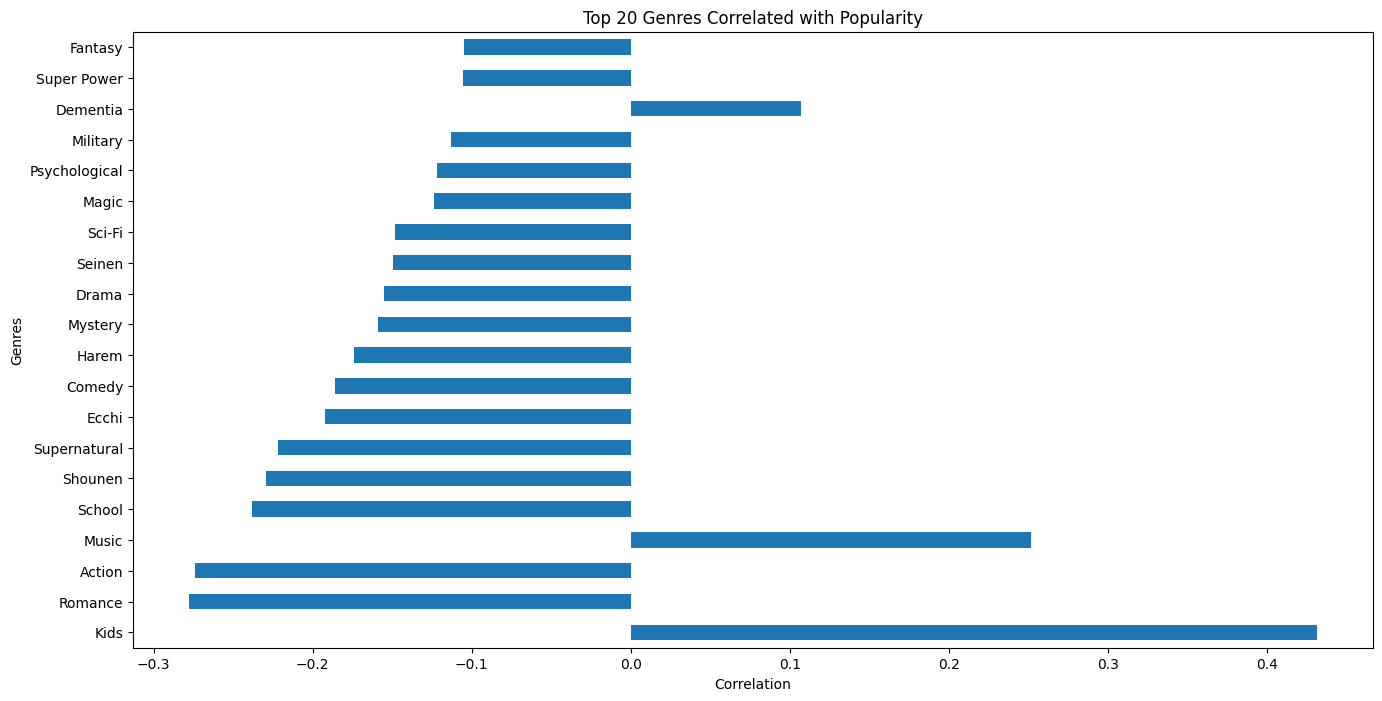

In [47]:
mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(animes_df['genre'])
genre_df = pd.DataFrame(genre_matrix, columns=mlb.classes_, index=animes_df.index)

genre_df['popularity'] = animes_df['popularity']

genre_corr = genre_df.corr()

genre_corr_popularity = genre_corr['popularity'].drop('popularity').sort_values(key=abs, ascending=False)

print("Top Genres Correlated with Popularity:\n", genre_corr_popularity.head(20))

def plot_correlations(correlations, title):
    plt.figure(figsize=(16, 8))
    correlations.plot(kind='barh')
    plt.title(title)
    plt.xlabel('Correlation')
    plt.ylabel('Genres')
    plt.show()

plot_correlations(genre_corr_popularity.head(20), 'Top 20 Genres Correlated with Popularity')

In [48]:
# Function to get genre combinations
def get_genre_combinations(genres, n):
    return [' & '.join(sorted(combo)) for combo in combinations(genres, n)]

# Process genre combinations
def process_genre_combinations(row):
    genres = row['genre']
    combos_2 = get_genre_combinations(genres, 2)
    combos_3 = get_genre_combinations(genres, 3)
    combos_4 = get_genre_combinations(genres, 4)
    return combos_2 + combos_3 + combos_4

animes_df['genre_combinations'] = animes_df.apply(process_genre_combinations, axis=1)

# Convert DataFrame to cuDF DataFrame
animes_gdf = cudf.DataFrame.from_pandas(animes_df)

# MultiLabelBinarizer for genre combinations
mlb = MultiLabelBinarizer(sparse_output=True)
genre_comb_matrix = mlb.fit_transform(animes_df['genre_combinations'])

# Convert sparse matrix to dense CuPy array
genre_comb_array = cp.array(genre_comb_matrix.todense())

# Convert CuPy array to cuDF DataFrame
genre_comb_df = cudf.DataFrame(genre_comb_array, columns=mlb.classes_)

# Check GPU memory usage
print("GPU memory usage after creating genre_comb_df:", cp.get_default_memory_pool().used_bytes() / 1e9, "GB")



/home/ubuntu/GitHub/anime-data-analytics-project/venv/lib/python3.11/site-packages/cupy/_creation/from_data.py:53: PerformanceWarning: Using synchronous transfer as pinned memory (2012081280 bytes) could not be allocated. This generally occurs because of insufficient host memory. The original error was: cudaErrorMemoryAllocation: out of memory
  return _core.array(obj, dtype, copy, order, subok, ndmin, blocking)


GPU memory usage after creating genre_comb_df: 0.0 GB


In [49]:
# Add popularity column to the cuDF DataFrame
popularity_array = cp.array(animes_gdf['popularity'].to_pandas().values)
genre_comb_df['popularity'] = popularity_array

# Calculate Spearman correlation using CuPy and cuDF
genre_comb_corr = cp.corrcoef(genre_comb_df.values.T)

# Extract correlation with popularity
popularity_index = list(genre_comb_df.columns).index('popularity')
correlations_with_popularity = genre_comb_corr[popularity_index, :-1]  # Exclude the popularity column itself


In [50]:
# Sort and display the correlations
sorted_correlations = cp.abs(correlations_with_popularity).argsort()[::-1].get()
sorted_genres = [genre_comb_df.columns[i] for i in sorted_correlations]
sorted_values = [correlations_with_popularity[i].get() for i in sorted_correlations]

print(pd.DataFrame({"Genre Combination": sorted_genres, "Correlation": sorted_values}).head(20))

            Genre Combination           Correlation
0            Comedy & Romance  -0.23720035408904017
1                Kids & Music   0.22354083845824851
2            Comedy & Shounen  -0.20717759716792927
3             Comedy & School  -0.20584053073662706
4       Action & Supernatural  -0.19142335874028243
5            Romance & School  -0.18976227167072515
6            Action & Fantasy  -0.18133458875762481
7             Action & Comedy   -0.1718749393132996
8             Drama & Romance  -0.16909711340817463
9              Comedy & Drama  -0.16897141640463123
10  Comedy & Romance & School  -0.16534512799001047
11             Comedy & Ecchi   -0.1608532648486696
12             Action & Drama  -0.15710451669811668
13             Comedy & Harem  -0.15512661238588804
14            Harem & Romance  -0.15506288291087444
15           Action & Shounen  -0.15332007318198568
16      Comedy & Supernatural  -0.14999035001949657
17            Ecchi & Romance  -0.14450057714174394
18          

In [51]:
sorted_values = [float(v) for v in sorted_values]
sorted_genres = [str(genre) for genre in sorted_genres]

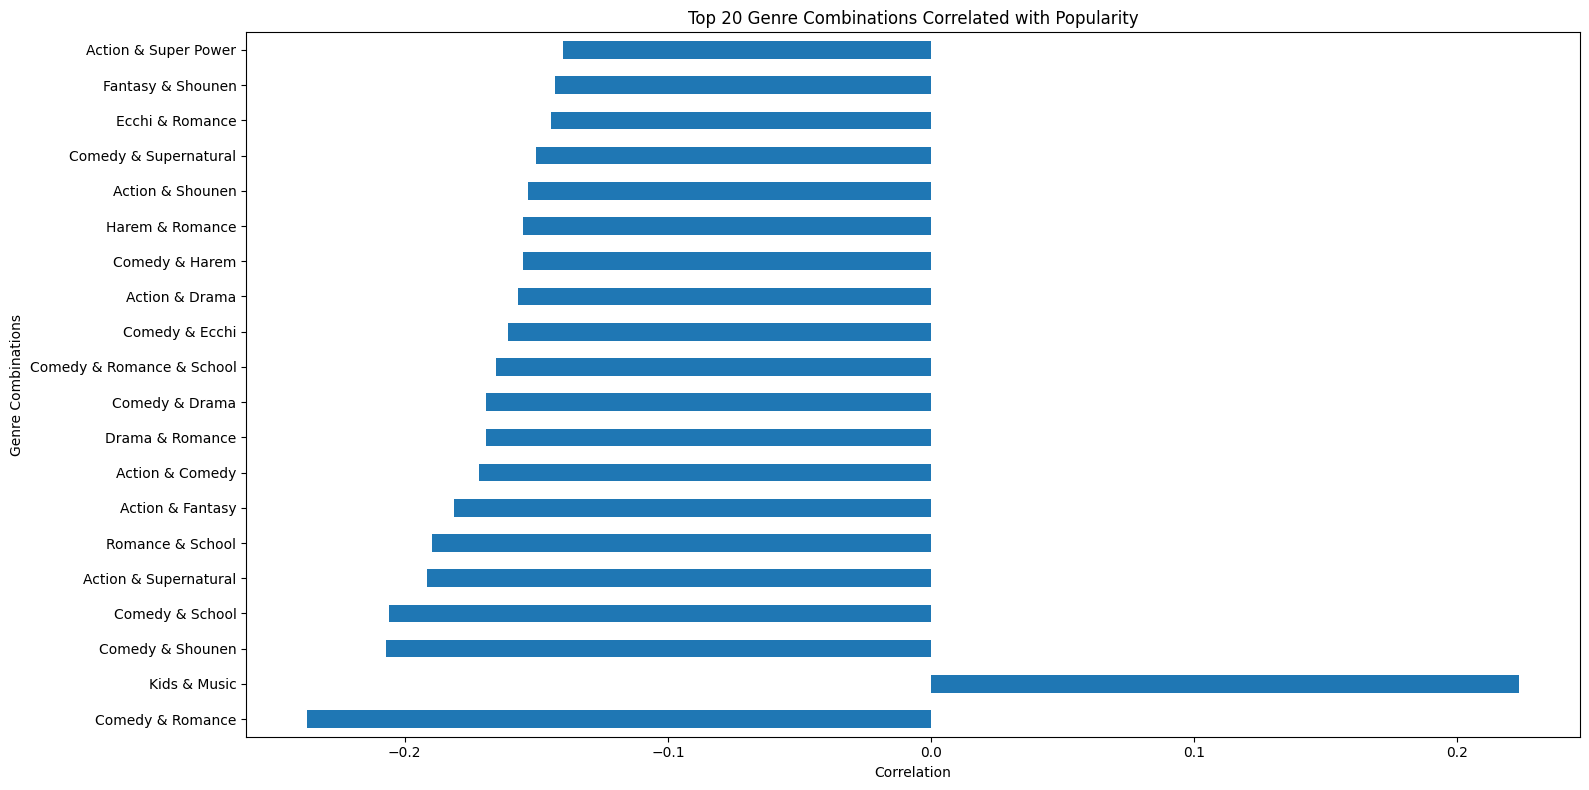

In [52]:
def plot_correlations(correlations, genre_combinations, title):
    plt.figure(figsize=(16, 8))
    pd.Series(correlations, index=genre_combinations).head(20).plot(kind='barh')
    plt.title(title)
    plt.xlabel('Correlation')
    plt.ylabel('Genre Combinations')
    plt.tight_layout()
    plt.show()

# Plot top 20 genre correlations with popularity
plot_correlations(sorted_values[:20], sorted_genres[:20], 'Top 20 Genre Combinations Correlated with Popularity')
